# Deep Convolutional GANs

This is a hands on experience building a Deep Convolutional Generative Adversarial Network (DCGAN). The following implementation is based on the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

More details about this notebook as well as a quick introduction to GANs can be found in the accompanied article [here](https://sthalles.github.io).

In [5]:
%matplotlib inline

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import gzip
import zipfile
import utils

## Getting the data

This network is built to support two datasets, the The Street View House Numbers (SVHN) and the MNIST dataset. To choose between them, just assign one of the option variables to the **dataset_name** variable.

In [6]:
MNIST_DATASET = 'mnist'
SVHN_DATASET = 'svhn'

In [7]:
dataset_name = MNIST_DATASET

In [8]:
dataset = utils.Dataset(dataset_name, shuffle=True)
print("Dataset shape:", dataset.images().shape)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz
Dataset shape: (65000, 32, 32, 1)


Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB), for the SVHN and 32x32x1 for the MNIST images. Note that for the MNIST dataset we opted to pad the 28x28 black and white images with 0s so that they match the SVHNs spatial dimensions. These are the real images we'll pass to the discriminator and what the generator will eventually fake.

This dataset object already does the required preprocessing, i.e. scale the images between -1 and 1 and it also has a ```next_batch()``` method for getting training mini-batches.

In [9]:
def display_images(dataset, figsize=(5,5)):
    fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=figsize,)
    for ii, ax in enumerate(axes.flatten()):
        if dataset_name == SVHN_DATASET:
            ax.imshow(dataset[ii,:,:,:], aspect='equal')
        elif dataset_name == MNIST_DATASET:
            ax.imshow(dataset[ii].reshape(32,32), cmap='gray')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)

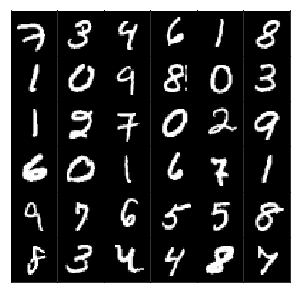

In [10]:
display_images(dataset.images())

These are Tensorflow's wrapper function for the most important routines we will be using in this implementation. According to the paper, the variables are initialized with a values from a normal distribution with mean of 0 and standard deviation of 0.02. Both convolutions and transpose convolutions have 'same' padding and them both use strides of 2 either to reduce in half or to double increase the inputs’ spatial dimensions.

In [11]:
def dense(x, out_units):
    return tf.layers.dense(x, out_units, activation=None, 
                           kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

def conv2d(x, output_space):
    return tf.layers.conv2d(x, output_space, kernel_size=5, strides=2, padding="same", activation=None, 
                            kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

def lrelu(x, alpha=0.2):
     # non-linear activation function
    return tf.maximum(alpha * x, x)

def batch_norm(x, training, epsilon=1e-5, momentum=0.9):
     return tf.layers.batch_normalization(x, training=training, epsilon=epsilon, momentum=momentum)
    
def transpose_conv2d(x, output_space):
    return tf.layers.conv2d_transpose(x, output_space, 5, strides=2, padding='same',
                                   kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

## Network Inputs

Here, just creating some placeholders like normal.

In [12]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stack layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3.

In [13]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        fc1 = dense(z, 4*4*512)
        
        # Reshape it to start the convolutional stack
        fc1 = tf.reshape(fc1, (-1, 4, 4, 512))
        fc1 = batch_norm(fc1, training=training)
        fc1 = tf.nn.relu(fc1)
        
        t_conv1 = transpose_conv2d(fc1, 256)
        t_conv1 = batch_norm(t_conv1, training=training)
        t_conv1 = tf.nn.relu(t_conv1)
        
        t_conv2 = transpose_conv2d(t_conv1, 128)
        t_conv2 = batch_norm(t_conv2, training=training)
        t_conv2 = tf.nn.relu(t_conv2)
        
        logits = transpose_conv2d(t_conv2, output_dim)
        
        out = tf.tanh(logits)
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU. 

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

In [14]:
def discriminator(x, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x?
        conv1 = conv2d(x, 64)
        conv1 = lrelu(conv1, alpha)
        
        conv2 = conv2d(conv1, 128)
        conv2 = batch_norm(conv2, training=training)
        conv2 = lrelu(conv2, alpha)
        
        conv3 = conv2d(conv2, 256)
        conv3 = batch_norm(conv3, training=training)
        conv3 = lrelu(conv3, alpha)

        # Flatten it
        flat = tf.reshape(conv3, (-1, 4*4*256))
        logits = dense(flat, 1)

        out = tf.sigmoid(logits)
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [15]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    tf.summary.scalar('mean_discriminator_output_prob_real', tf.reduce_mean(d_model_real))
        
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    tf.summary.scalar('mean_discriminator_output_prob_fake', tf.reduce_mean(d_model_fake))
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

Here is a function for displaying generated images.

In [17]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
        
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        ax.set_adjustable('box-forced')
        
        if dataset_name == 'svhn':
            img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8) # Scale back to 0-255
            im = ax.imshow(img, aspect='equal')
        elif dataset_name == 'mnist':
            img = (img - img.min()) / (img.max() - img.min()) # Scale back to 0-1
            im = ax.imshow(img.reshape(32,32), cmap='Greys_r')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an errror without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [18]:
real_size = dataset.images().shape[1:]
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 15
alpha = 0.2
beta1 = 0.5

In [ ]:
tf.reset_default_graph()

input_real, input_z = model_inputs(real_size, z_size)
d_loss, g_loss = model_loss(input_real, input_z, real_size[2], alpha=0.2)
d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, 0.5)

saver = tf.train.Saver()
sample_z = np.random.uniform(-1, 1, size=(36, z_size))

samples, losses = [], []
image_counter = 0

Tensor("generator/Relu:0", shape=(?, 4, 4, 512), dtype=float32)
Tensor("generator/Relu_1:0", shape=(?, 8, 8, 256), dtype=float32)
Tensor("generator/Relu_2:0", shape=(?, 16, 16, 128), dtype=float32)
Tensor("generator/conv2d_transpose_3/BiasAdd:0", shape=(?, 32, 32, 1), dtype=float32)


Dataset shuffled successfully.
Epoch 1/15... Discriminator Loss: 1.7769... Generator Loss: 0.0665
Tensor("generator_1/Relu:0", shape=(?, 4, 4, 512), dtype=float32)
Tensor("generator_1/Relu_1:0", shape=(?, 8, 8, 256), dtype=float32)
Tensor("generator_1/Relu_2:0", shape=(?, 16, 16, 128), dtype=float32)
Tensor("generator_1/conv2d_transpose_3/BiasAdd:0", shape=(?, 32, 32, 1), dtype=float32)


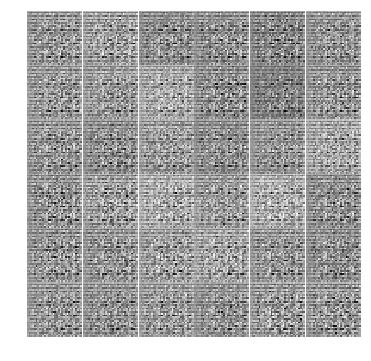

Epoch 1/15... Discriminator Loss: 2.3972... Generator Loss: 0.7832
Epoch 1/15... Discriminator Loss: 2.1067... Generator Loss: 1.9113
Epoch 1/15... Discriminator Loss: 2.4679... Generator Loss: 2.0596
Epoch 1/15... Discriminator Loss: 1.6058... Generator Loss: 2.9512
Epoch 1/15... Discriminator Loss: 0.6469... Generator Loss: 1.9148
Epoch 1/15... Discriminator Loss: 1.2894... Generator Loss: 2.1387
Epoch 1/15... Discriminator Loss: 1.2666... Generator Loss: 1.0698
Epoch 1/15... Discriminator Loss: 0.8874... Generator Loss: 1.9405
Epoch 1/15... Discriminator Loss: 0.6019... Generator Loss: 1.4677
Epoch 1/15... Discriminator Loss: 1.4081... Generator Loss: 2.2771
Tensor("generator_2/Relu:0", shape=(?, 4, 4, 512), dtype=float32)
Tensor("generator_2/Relu_1:0", shape=(?, 8, 8, 256), dtype=float32)
Tensor("generator_2/Relu_2:0", shape=(?, 16, 16, 128), dtype=float32)
Tensor("generator_2/conv2d_transpose_3/BiasAdd:0", shape=(?, 32, 32, 1), dtype=float32)


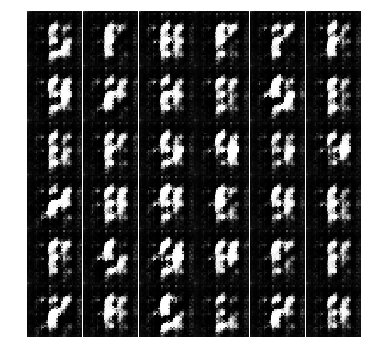

Epoch 1/15... Discriminator Loss: 1.1185... Generator Loss: 1.7799
Epoch 1/15... Discriminator Loss: 0.9313... Generator Loss: 1.7209
Epoch 1/15... Discriminator Loss: 0.9290... Generator Loss: 2.0406
Epoch 1/15... Discriminator Loss: 1.0573... Generator Loss: 1.8394
Epoch 1/15... Discriminator Loss: 1.3167... Generator Loss: 1.0953
Epoch 1/15... Discriminator Loss: 1.3244... Generator Loss: 0.9530
Epoch 1/15... Discriminator Loss: 1.1723... Generator Loss: 1.7415


In [ ]:
steps = 0
with tf.Session() as sess:
    # Merge all the summaries and write them out
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('./', sess.graph)
    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x in dataset.next_batch(batch_size):
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

            # Update the discriminator network
            _, summary, train_loss_d = sess.run([d_opt, merged, d_loss], feed_dict={input_real: x, input_z: batch_z})
            
            # Update the generator twice two avoid the rapid convergence of the discriminator
            _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: x})
            _, train_loss_g = sess.run([g_opt, g_loss], feed_dict={input_z: batch_z, input_real: x})

            if steps % 10 == 0:
                train_writer.add_summary(summary, steps)

                print("Epoch {}/{}...".format(e+1, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                # Save losses to view after training
                losses.append((train_loss_d, train_loss_g))
            
            if steps % 100 == 0:
                # At the end of each batch, sample from some data from the generator display and save it
                gen_samples = sess.run(
                               generator(input_z, real_size[2], reuse=True, training=False),
                               feed_dict={input_z: sample_z})
                samples.append(gen_samples)
                _ = view_samples(-1, samples, 6, 6, figsize=(6,6))

                # save the samples to disk
                folder = "./video"
                if not os.path.isdir(folder):
                    os.makedirs(folder)

                plt.savefig(folder + "/file%02d.png" % image_counter)
                image_counter += 1
                plt.show()
                
            steps += 1
    # saver.save(sess, './checkpoints/generator.ckpt')

In [17]:
import matplotlib.cm as cm
import os
import subprocess
import glob

def generate_video(folder="./video"):
    os.chdir(folder)
    subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        'video_mnist.mp4'
    ])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)

In [18]:
generate_video()

## Hyperparameters

GANs are very senstive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [ ]:
dataset = Dataset(trainset, testset)

losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

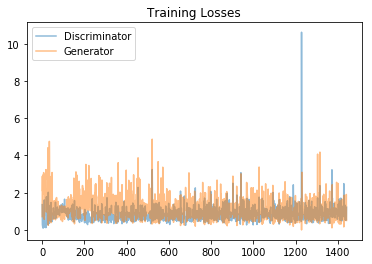

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

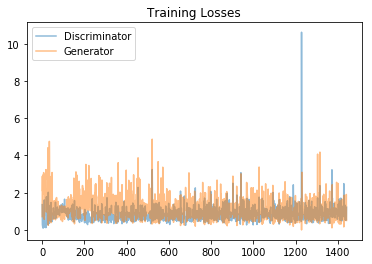

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

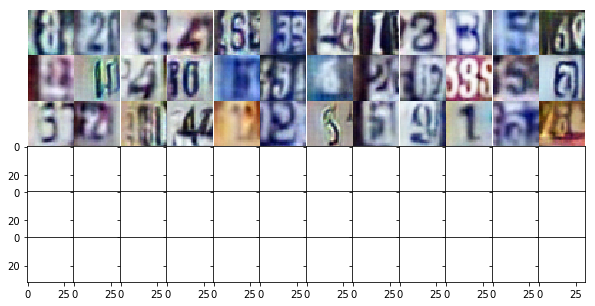

In [22]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

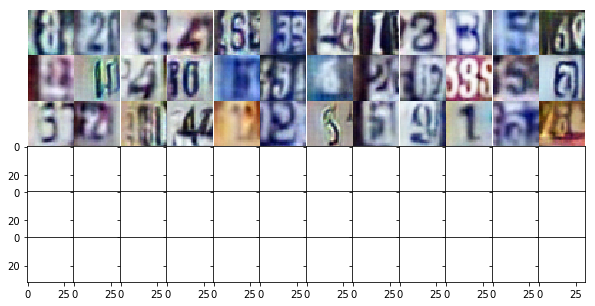

In [23]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))